### Init

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support,balanced_accuracy_score
from gensim.models import Word2Vec,FastText
from nltk.tokenize import MWETokenizer,word_tokenize
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm
import copy
import gc
import os
import time
import warnings

path = r"C:\YZC\NUS\Semester 2\CS4248 Natural Language Processing\Project\scicite"
os.chdir(path)
if torch.cuda.is_available():
    device = 'cuda'
else: device = 'cpu'

#### Load data

In [2]:
df = pd.read_json('train.jsonl',lines=True)
df_test = pd.read_json('test.jsonl',lines=True)
df.head()

source  citeEnd                                        sectionName  \
0  explicit    175.0                                       Introduction   
1  explicit     36.0  Novel Quantitative Trait Loci for Seminal Root...   
2  explicit    228.0                                       Introduction   
3  explicit    110.0                                         Discussion   
4  explicit    239.0                                         Discussion   

   citeStart                                             string       label  \
0      168.0  However, how frataxin interacts with the Fe-S ...  background   
1       16.0  In the study by Hickey et al. (2012), spikes w...  background   
2      225.0  The drug also reduces catecholamine secretion,...  background   
3       46.0  By clustering with lowly aggressive close kin ...  background   
4      234.0  Ophthalmic symptoms are rare manifestations of...  background   

   label_confidence                             citingPaperId  \
0               1.0  1872080baa7d30ec8fb87be9a65358cd3a7fb649   
1               1.0  ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b   
2               1.0  9cdf605beb1aa1078f235c4332b3024daa8b31dc   
3               1.0  d9f3207db0c79a3b154f3875c9760cc6b056904b   
4               1.0  88b86556857f4374842d2af2e359576806239175   

                               citedPaperId  isKeyCitation  \
0  894be9b4ea46a5c422e81ef3c241072d4c73fdc0           True   
1  b6642e19efb8db5623b3cc4eef1c5822a6151107           True   
2  4e6a17fb8d7a3cada601d942e22eb5da6d01adbd          False   
3  2cc6ff899bf17666ad35893524a4d61624555ed7          False   
4  a5bb0ff1a026944d2a47a155462959af2b8505a8          False   

                                                  id  \
0  1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...   
1  ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...   
2  9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...   
3  d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...   
4  88b86556857f4374842d2af2e359576806239175>a5bb0...   

                                           unique_id  excerpt_index label2  \
0  1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...             11    NaN   
1  ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...              2    NaN   
2  9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...              0    NaN   
3  d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...              3    NaN   
4  88b86556857f4374842d2af2e359576806239175>a5bb0...              2    NaN   

   label2_confidence  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN

### Preprocessing

In [3]:
def null_test():
    null_cols = []
    for col in df.columns:
        if df[col].isnull().any(): null_cols.append(col)
    print(null_cols)

#### Processing functions

In [4]:
tk = MWETokenizer([('<','bos','>'),('<','eos','>')],separator='')
# tk.add_mwe([('<','bos','>'),('<','eos','>')])

def convert_label(value):
    if value == 'background':
        label = 0
    elif value == 'method':
        label = 1
    elif value == 'result':
        label = 2
    return label

def NA_impute(df):
    df['label2'] = df['label2'].fillna('cant_determine')
    try:
        print(len(df).df.columns)
        df = df.drop(columns='label2_confidence',axis=1)
        df_type = 'train'
    except:
        df_type = 'test'
    df['label_confidence'] = df['label_confidence'].fillna(df['label_confidence'].mean())
    df['citeStart'] = df['citeStart'].fillna(df['citeStart'].mean().astype(np.int64))
    df['citeEnd'] = df['citeEnd'].fillna(df['citeEnd'].mean().astype(np.int64))
    df['source'] = df['source'].fillna('unknown')
    df['sectionName'] = df['sectionName'].fillna('unknown')
    return df, df_type

def check_sectionName_direct(sn):
    targets = ['method','background','result']
    result = sn + ' '
    for word in targets:
        if word in sn or word.upper() in sn or word[0].upper()+word[1:] in sn:
            result = ''
            break
    return result.lower()
            
def add_sectionName(df,indirect=False):
    if indirect == False:
        df['string_lower_sn'] = df.apply(lambda x:x.sectionName.lower()+' '+x.string_lower,axis=1)
        df['tokens_lower_sn'] = df['string_lower_sn'].apply(lambda x: tk.tokenize(word_tokenize(x)))
    else:
        df['string_lower_sn1'] = df.apply(lambda x:check_sectionName_direct(x.sectionName)+x.string_lower,axis=1)
        df['tokens_lower_sn1'] = df['string_lower_sn1'].apply(lambda x: tk.tokenize(word_tokenize(x)))
    return df

def process_df(df):
    df, df_type = NA_impute(df)
    for col in ['citeStart','citeEnd']:
        df[col] = df[col].astype('int64')
    feature_cols = ['source', 'citeEnd', 'sectionName', 'citeStart', 'label_confidence', 'citingPaperId', 'citedPaperId', 'isKeyCitation', 'excerpt_index', 'label2', 'label2_confidence']
    if df_type == 'test':
        feature_cols.remove('label2_confidence')
    df['edited_string'] = ''
    for col in feature_cols:
        df['edited_string'] += col + ': ' + df[col].astype(str) + '[SEP]'
    df['edited_string'] += df['string']
    df['tagged_string'] = '<BOS>' + df['string'] + '<EOS>'
    df['label_num'] = df['label'].apply(lambda x: convert_label(x))
    df['string_lower'] = df['tagged_string'].apply(lambda x: x.lower())
    df['tokens_lower'] = df['string_lower'].apply(lambda x: tk.tokenize(word_tokenize(x)))  
    return df

In [5]:
df_train = process_df(df)
df_test = process_df(df_test)
# Remove outliers, i.e. lengthy sentences
df_train = df_train.loc[df_train['tokens_lower'].str.len() <= 100]
df_train = df_train.reset_index(drop=True)

In [6]:
'''
Hypotheses:
Word embeddings
Combine word embeddings with features
Attention mechanism
Include the sentences immediately before and after
Activation functions

Open questions
- Where can we get more contextual information? How to incorporate?
- variables:
    - lower case? stopwords? lemmatization? any words to include?
'''
no_print = True

#### Preparing Embedding Arrays

In [7]:
'''
input array (batch_first = True): N (batch size) * L (sequence length) * H_in (input size)
'''
def generate_X(df,token_col,model,seq_len,vec_size):
    '''
    token_col: col for tokens in dataframe
    model: word vectorization model
    '''
    X = []
    for i in tqdm(range(len(df))):
        i_arr = [model.wv[token] for token in df.at[i,token_col]]
        if len(i_arr) < seq_len:
            while len(i_arr) < seq_len:
                i_arr.append(np.zeros(vec_size))
        elif len(i_arr) > seq_len:
            i_arr = i_arr[:seq_len]
        X.append(i_arr)
    return np.array(X)

class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].to_numpy()

def generate_static_features(df):
    num_cols = ['citeStart','citeEnd','excerpt_index','isKeyCitation']
    cat_cols = ['label2']
    num_pipeline = Pipeline([
        ('selector',DataFrameSelector(num_cols)),
        ('scaler',StandardScaler())
    ])
    cat_pipeline = Pipeline([
        ('selector',DataFrameSelector(cat_cols)),
        ('ohe',OneHotEncoder())
    ])
    combined_pipeline = FeatureUnion([
        ('num',num_pipeline),
        ('cat',cat_pipeline)
    ])
    sf = combined_pipeline.fit_transform(df)
    return sf

def convert_y(y): # for training and validation labels. For y_val, keep one multi-target and one single-target version
    y_nn = np.zeros([y.shape[0],3])
    for i in range(len(y)):
        if y[i] == 0:
            y_nn[i,0] = 1
        elif y[i] == 1:
            y_nn[i,1] = 1
        elif y[i] == 2: 
            y_nn[i,2] = 1
    return y_nn

def to_tensor(arr,dtype='Float'):
    if dtype == "Float":
        arr = torch.from_numpy(arr).type(torch.FloatTensor)
    elif dtype == "Long":
        arr = torch.from_numpy(arr).type(torch.LongTensor)
    return arr

def check_dist_y(y,n=None):
    '''
    y: torch array
    n: last index of sample
    '''
    if n == None:
        print(torch.sum(y_train,dim=0))
    else:
        print(torch.sum(y_train[:n],dim=0))

In [8]:
vec_size = 200 # hp
seq_length = 100 # max word length based on tokenization, including padding tokens. Outliers removed (~ 1.5% of dataset)
corpus = df_train['tokens_lower'].tolist()
ft = FastText(corpus,vector_size=vec_size,epochs=10)
sf_core = generate_static_features(df_train)
sf_test = generate_static_features(df_test)
y_core = df_train['label_num'].to_numpy()
y_test = df_test['label_num'].to_numpy()

#####  For Subsequent Runs (with Tensors Saved), Ignore this Cell:
*i.e. Only run once*

In [ ]:
X_core = generate_X(df_train,'tokens_lower',
                   ft,seq_length,vec_size)
X_test = generate_X(df_test,'tokens_lower',
                   ft,seq_length,vec_size)
X_train, X_val, sf_train, sf_val, y_train, y_val = train_test_split(X_core,sf_core,y_core,test_size=0.2,random_state= 1)
y_train, y_val_nn = convert_y(y_train),convert_y(y_val)
X_train, X_val, X_test, sf_train, sf_val, sf_test = to_tensor(X_train), to_tensor(X_val), to_tensor(X_test), to_tensor(sf_train.toarray()), to_tensor(sf_val.toarray()), to_tensor(sf_test.toarray()),
y_train, y_val_nn = to_tensor(y_train), to_tensor(y_val_nn)
torch.save([X_train,X_val,X_test,sf_train,sf_val,sf_test,y_train,y_val_nn],'data_arrays_v0.pt') # embeddings only
np.savez('y_arr_v0.npz',y_val=y_val,y_test=y_test)

##### For Subsequent Runs (Tensors Saved), Resume from this Cell:
Note: MUST RUN the two cells below. The first one is required for all tests except RNN_Att_StatFeats with SectionName

In [9]:
# Load data
X_train,X_val,X_test,sf_train,sf_val,sf_test,y_train,y_val_nn = torch.load('data_arrays_v0.pt')
data = np.load('y_arr_v0.npz')
y_val = data['y_val']
y_test = data['y_test']

# Utility/Essential parameters
vec_size = 200 # hp
seq_length = 100 # max word length based on tokenization, including padding tokens
models_generated = ['rnn_0','rnn_a','rnn_a_sf','rnn_a_sf1','rnn_a_sf2','rnn_a_sf3']

In [10]:
def check_dist(arr):
    unique, counts = np.unique(arr,return_counts=True)
    return list(zip(unique,counts))
    
def resample_arr(X,y,rng): # Not used
    y_0 = y[:,0] == 1 # class 0
    y_non0 =  y[:,0] == 0 # class 1 or 2
    idx_0 = y_0.nonzero().numpy() # list of lists (numpy)
    idx_non0 = y_non0.nonzero() # list of lists (torch)
    idx_sample_0 = rng.choice(idx_0,len(idx_0)//3) # as size of class 0 ~ 4x that of other classes
    idx_sample_0 = torch.from_numpy(idx_sample_0).type(torch.LongTensor)
    idx_sample = torch.cat((idx_sample_0.squeeze(1),idx_non0.squeeze(1))) 
    del y_0,y_non0,idx_0,idx_non0,idx_sample_0
    return X[idx_sample], y[idx_sample]

def plot_attention_weights(val_idx_num,loaded_rnn,sample_string_length=35,tokens_col='tokens_lower'):
    '''
    if an array mismatch error is triggered, just try a larger sampe_string_lenth value
    '''
    attn_w = loaded_rnn._parameters['attn_w'].detach().cpu().numpy()
    def pad_string(string,n=sample_string_length):
        while len(string) < n:
            string.append('')
        return string
    train_idx,val_idx = train_test_split(np.arange(len(df_train)),test_size=0.2,random_state= 1)
    sample_string = df_train.at[val_idx[val_idx_num],tokens_col].copy()
    sample_string = pad_string(sample_string)
    x_axis = [i for i in range(sample_string_length)]
    plt.figure(figsize=(30,5))
    print(sample_string)
    print(attn_w[val_idx_num][0][0:sample_string_length])
    plt.bar(sample_string,attn_w[val_idx_num][0][0:sample_string_length])
    plt.xticks(x_axis, sample_string, rotation=45)
    plt.show()

def train_and_save(model,filename,
                   loss_fn,optimizer,
                   loader,
                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs):
    '''
    sf: [bool] whether static features are included or not
    '''
    X_val, sf_val = kwargs.get('X_val', None),kwargs.get('sf_val', None)
    best_loss = float('inf')
    best_epoch = 0
    for epoch in tqdm(range(n_epochs)):
        model.train()
        rng = np.random.default_rng()
        
        if sf == False:
            for X_batch, y_batch in loader:
                y_pred_batch = model(X_batch)
                loss = loss_fn(y_pred_batch,y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        else:
            for X_batch, sf_batch, y_batch in loader:
                y_pred_batch = model(X_batch,sf_batch)
                loss = loss_fn(y_pred_batch,y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            if sf == False:
                y_pred_nn = model(X_val)
            else:
                y_pred_nn = model(X_val,sf_val)
            y_pred = torch.argmax(y_pred_nn,1).detach().cpu()
            y_dist = check_dist(y_pred) # Troubleshooting 
            print(y_dist) # Troubleshooting
            bal_accuracy = balanced_accuracy_score(y_val,y_pred)
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                precision, recall, fscore, support = precision_recall_fscore_support(y_val,y_pred,average='weighted')
            val_loss = loss_fn(y_pred_nn,y_val_nn)
            tqdm.write(f"Epoch{epoch+1}: val loss={val_loss}, balanced accuracy={bal_accuracy}, precision={precision}, recall={recall}, fscore={fscore}")
            
            # Early Stopping
            if val_loss < best_loss:
                best_loss = val_loss
                best_epoch = epoch + 1
                best_model_weights = copy.deepcopy(model.state_dict())
                patience = 10
            else:
                patience -= 1
                if patience == 0:
                    print(f'Early stopping triggered at epoch {epoch+1}. Best model is from epoch {best_epoch}.')
                    break
        
        # For memory saving
        try:
            del X_sample,y_sample
            gc.collect()
        except:
            True
    torch.save(best_model_weights,filename)
    return model

#### Naive RNN

In [13]:
# See documentation: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

class RNN_base(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN_base,self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size,hidden_size,batch_first=True)
        self.ff = nn.Linear(hidden_size,output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self,x):
        h0 = torch.zeros(1,x.size(0),self.hidden_size).to(device)
        # 1: number of RNN layers. x.size(0): batch_size.
        _, hidden = self.rnn(x,h0)
        output = self.ff(hidden[-1])
        return output

In [14]:
# HPs
hidden_size = 150
batch_size = 2
lr = 0.0004
mode = 'default' 
'''
mode: default or sequential. 
   default: using RNN_base
   sequential: using nn.Sequential. to view network weights
'''

# Save memory
for var in models_generated:
    if var in globals(): del var
gc.collect()

# Build and train
class generate_h(nn.Module):
    def __init__(self,hidden_size):
        super(generate_h,self).__init__()
        self.hidden_size = hidden_size
    def forward(self,x):
        return x,torch.zeros(1,x.size(0),self.hidden_size).to(device)

class extract_h(nn.Module):
    def forward(self,x):
        _, hidden = x
        return hidden[-1]
    
class RNN_wrapper(nn.Module):
    def __init__(self,vec_size,hidden_size,batch_first):
        super(RNN_wrapper,self).__init__()
        self.rnn = nn.RNN(vec_size,hidden_size,batch_first=batch_first)
    def forward(self,h):
        return self.rnn(h[0],h[1])
    
if mode == 'default':
    rnn0 = RNN_base(input_size=vec_size,hidden_size=hidden_size,output_size=y_train.shape[1]).to(device)
elif mode == 'sequential':
    rnn0 = nn.Sequential(
        generate_h(hidden_size),
        RNN_wrapper(vec_size,hidden_size,batch_first=True),
        extract_h(),
        nn.Linear(hidden_size,y_train.shape[1])
    ).to(device)

optimizer = optim.Adam(rnn0.parameters(),lr=lr)
# Weighted loss required for RNN to not assign all labels to one class
weights = torch.tensor([1, 2, 2.5]).to(device) #hp
loss_fn = nn.CrossEntropyLoss(weight=weights)
loader = DataLoader(TensorDataset(X_train.to(device),y_train.to(device)),batch_size=batch_size)
'''
train_and_save args: model,filename,
                   loss_fn,optimizer,
                   loader,
                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs
'''
rnn0 = train_and_save(rnn0,'RNN_v0.pt',
                      loss_fn,optimizer,
                      loader,
                      y_val_nn.to(device),y_val,X_val=X_val.to(device))

'\ntrain_and_save args: model,filename,\n                   loss_fn,optimizer,\n                   loader,\n                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs\n'

Get model weights:

In [15]:
rnn0 = nn.Sequential(
    generate_h(hidden_size),
    RNN_wrapper(vec_size,hidden_size,batch_first=True),
    extract_h(),
    nn.Linear(hidden_size,y_train.shape[1])
)
rnn0.load_state_dict(torch.load('RNN_v1.pt'))

'''
rnn_w:
matrix 1 (0,2): input (x) to hidden (h_t)
matrix 2 (1,3): h_t-1 to h_t
2 & 3 are probably bias vectors
'''
ff1_w = rnn0[3].weight
rnn_w = rnn0[1].rnn.all_weights[0]

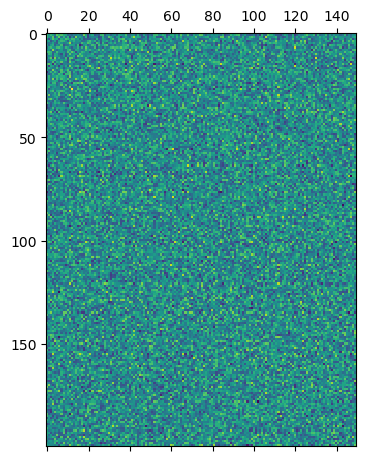

In [92]:
plt.matshow(rnn_w[0].detach().numpy().T)

#### RNN with Attention

In [12]:
# Reference: https://github.com/mttk/rnn-classifier/blob/master/model.py

# Self attention
class Attention(nn.Module):
    def __init__(self):
        super(Attention,self).__init__()
        
    def forward(self,dec_hidden_state,enc_hidden_states):
        '''
        ('query': hidden from rnn) dec_hidden_states: 1 * batch_size * hidden_size
        ('key'/'value': output from rnn) enc_hidden_state: batch_size * seq_len * hidden_size
        '''
        attn_w = torch.bmm(dec_hidden_state.transpose(0,1),enc_hidden_states.transpose(1,2)) # (B*1*H,B*H*L)
        attn_w = torch.nn.functional.softmax(attn_w.squeeze(1),dim=1) # need to standardize with ^. (B*1*L -> B*L)
        context = torch.bmm(enc_hidden_states.transpose(1,2),attn_w.unsqueeze(2)).squeeze(2) # (B*H*L,B*L*1)
        return torch.cat((context,dec_hidden_state.squeeze(0)),dim=1) # batch_size * (2*hidden_size)
        
class RNN_Attn(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_heads=1,mode='default',seq_length=seq_length):
        super(RNN_Attn,self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size,hidden_size,batch_first=True)
        self.mode = mode
        if mode == 'default':
            self.attn = Attention()
        elif mode == 'multihead':
            self.attn = nn.MultiheadAttention(hidden_size,num_heads,batch_first=True)
        self.dec = nn.Linear(2*hidden_size,output_size) # define context_size
        self.attn_w = nn.Parameter(torch.zeros(1624, 1,seq_length)) # Hard-coded
#         self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        h0 = torch.zeros(1,x.size(0),self.hidden_size).to(device) # 1: number of RNN layers. x.size(0): batch_size.
        output, hidden = self.rnn(x,h0) # hidden: enc_hidden. output: dec_hidden
        if self.mode == 'default':
            c_h = self.attn(hidden,output)
        elif self.mode == 'multihead':
            context,attn_w = self.attn(hidden.transpose(0,1),output,output)
            self.attn_w = nn.Parameter(attn_w)
            c_h = torch.cat((context.squeeze(1),hidden.squeeze(0)),dim=1)
        output = self.dec(c_h)
#         output = self.softmax(output)
        return output

In [37]:
# HPs
hidden_size = 70
batch_size = 2 # OOM when batch_size >= 4
lr = 0.0002
mode = 'multihead'
'''
mode: default or multihead. 
   default: using custom Attention class
   multihead: using nn.MultiheadAttention. to view attention weights
'''

# Save memory
for var in models_generated:
    if var in globals(): del var
gc.collect()

# Build and train
rnn_a = RNN_Attn(input_size=vec_size,hidden_size=hidden_size,output_size=y_train.shape[1],mode=mode).to(device)
optimizer = optim.Adam(rnn_a.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
loader = DataLoader(TensorDataset(X_train.to(device),y_train.to(device)),batch_size=batch_size)
'''
train_and_save args: model,filename,
                   loss_fn,optimizer,
                   loader,
                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs
'''
rnn_a = train_and_save(rnn_a,'RNN_Attn_v0.pt',
                     loss_fn,optimizer,
                     loader,y_val_nn.to(device),y_val,X_val=X_val.to(device))

  0%|          | 0/40 [00:00<?, ?it/s]

[(0, 987), (1, 448), (2, 189)]
Epoch1: val loss=0.4780689477920532, balanced accuracy=0.7616794192424444, precision=0.8112835531085141, recall=0.812192118226601, fscore=0.8105345154555792
[(0, 985), (1, 432), (2, 207)]
Epoch2: val loss=0.4578656256198883, balanced accuracy=0.7790838557645281, precision=0.8176860491074261, recall=0.8189655172413793, fscore=0.817834272950728
[(0, 975), (1, 427), (2, 222)]
Epoch3: val loss=0.4511185884475708, balanced accuracy=0.7873654512309974, precision=0.8183961646779623, recall=0.8195812807881774, fscore=0.8188206211521146
[(0, 971), (1, 425), (2, 228)]
Epoch4: val loss=0.448363333940506, balanced accuracy=0.7870708889616452, precision=0.8173432775920726, recall=0.8183497536945813, fscore=0.8177225626595703
[(0, 970), (1, 423), (2, 231)]
Epoch5: val loss=0.44693639874458313, balanced accuracy=0.7878267468603602, precision=0.8180874024962261, recall=0.8189655172413793, fscore=0.8183925773474195
[(0, 962), (1, 426), (2, 236)]
Epoch6: val loss=0.4465259

In [14]:
hidden_size = 70
rnn_a = RNN_Attn(input_size=vec_size,hidden_size=hidden_size,output_size=y_train.shape[1],mode='multihead')
rnn_a.load_state_dict(torch.load('RNN_Attn_v0.pt'))
train_idx,val_idx = train_test_split(np.arange(len(df_train)),test_size=0.2,random_state= 1)
val_idx[4], val_idx[7]

(592, 4216)

In [55]:
print(df_train.at[592,'label'],df_train.at[4216,'label'])

method method


In [51]:
rnn_a = rnn_a.to(device)
pred_sample = rnn_a(X_val[[4,7]].to(device)) 
pred_sample # background, method, result

tensor([[ 1.5110, -0.1271, -2.9534],
        [-0.9117,  1.1407, -0.4743]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

['<bos>', 'cddo-me', 'is', 'a', 'synthetic', 'triterpenoid', 'that', 'was', 'under', 'phase', 'iii', 'clinical', 'development', 'for', 'the', 'treatment', 'of', 'advanced', 'chronic', 'kidney', 'disease', '(', '37', ',', '38', ')', 'however', ',', 'due', 'to', 'adverse', 'events', 'in', 'the', 'phase', 'iii', 'clinical', 'trial', ',', 'further', 'development', 'of', 'cddo-me', 'was', 'terminated', '(', '39', ')', '.', '<eos>']
[0.03774728 0.00561618 0.00661299 0.00936698 0.01770921 0.0149009
 0.01665738 0.01912827 0.01493241 0.02645182 0.00459825 0.01737464
 0.01183775 0.00258908 0.00330136 0.04036105 0.00130307 0.02383065
 0.01004767 0.00173527 0.0046542  0.00253775 0.00587334 0.00046281
 0.01224723 0.0014506  0.06493326 0.00078144 0.0332244  0.00742744
 0.01179702 0.034137   0.00155876 0.00600233 0.02702094 0.00608735
 0.02133738 0.01194377 0.00071583 0.06326871 0.01881324 0.00108966
 0.00766496 0.02168343 0.13923413 0.00342117 0.00935118 0.00156186
 0.00712429 0.00960178]


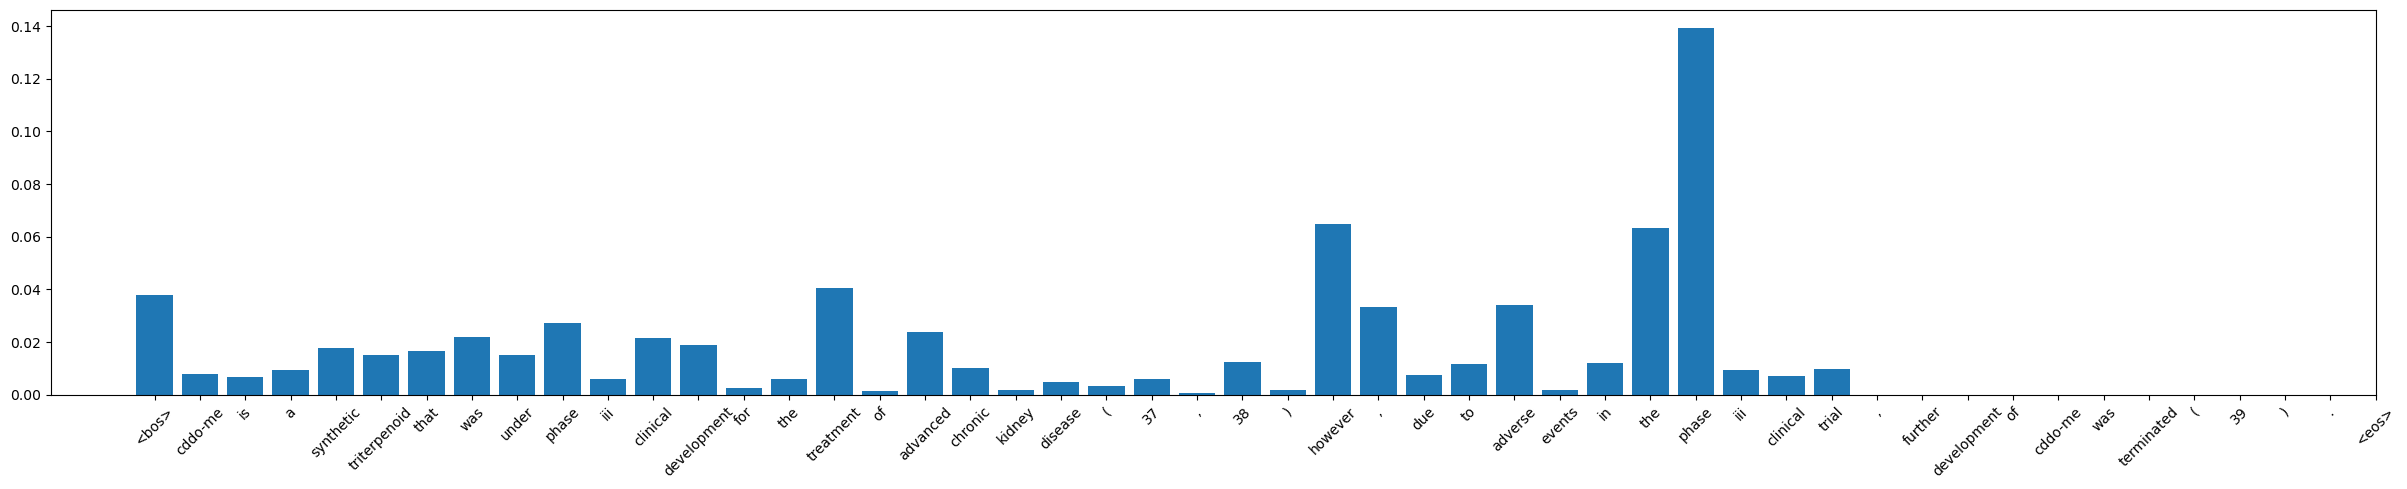

In [33]:
rnn_a = RNN_Attn(input_size=vec_size,hidden_size=hidden_size,output_size=y_train.shape[1],mode='multihead')
rnn_a.load_state_dict(torch.load('RNN_Attn_v0.pt'))
plot_attention_weights(4,rnn_a,sample_string_length=50)

['<bos>', 'the', 'remaining', 'descriptive', 'data', 'were', 'collected', 'via', 'observation', 'during', 'the', 'field', 'site', 'characterization', ',', 'and', 'during', 'previous', 'experiments', '[', '19,20', ']', '.', '<eos>']
[0.02574272 0.00209719 0.03087618 0.04711092 0.08004268 0.02930432
 0.2335199  0.01561472 0.04350522 0.00380977 0.00400799 0.04068992
 0.02010781 0.01546128 0.00045193 0.00203622 0.00237378 0.08762199
 0.11256085 0.00266463 0.00635205 0.00173255 0.00325728 0.00556653]


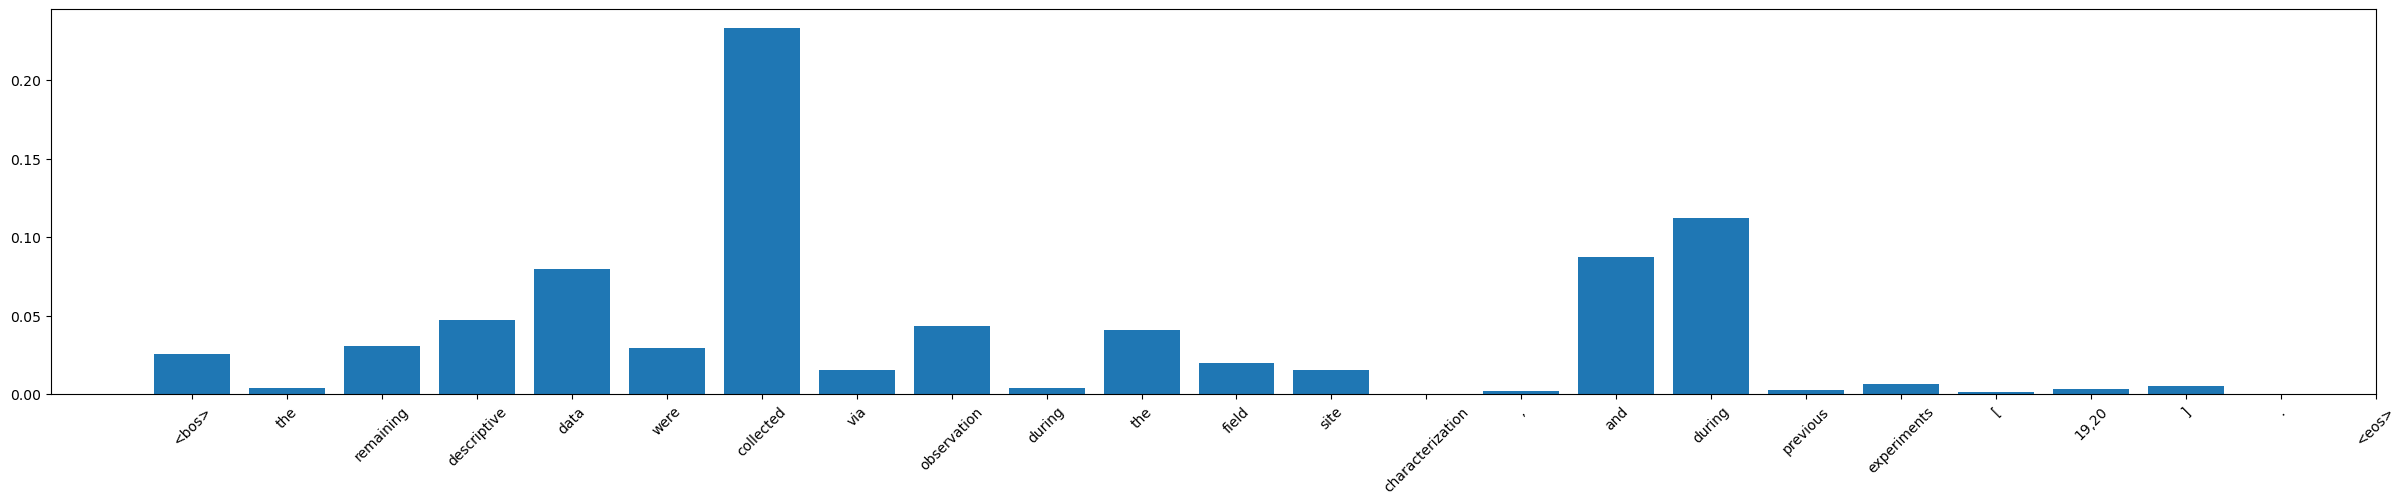

In [34]:
plot_attention_weights(7,rnn_a,sample_string_length=24)

In [ ]:
'''
(Reference) 
Getting model weights: 
https://stackoverflow.com/questions/44130851/simple-lstm-in-pytorch-with-sequential-module
https://discuss.pytorch.org/t/how-to-get-all-weights-of-rnn-in-pytorch/33794/2

Visualizing attention vector:
https://www.linkedin.com/advice/0/how-do-you-interpret-visualize-attention
'''
no_print = True

#### RNN_Attn with Static Features

Build and Train Model:

In [13]:
class SwiGLU(nn.Module):
    def __init__(self,hidden_size):
        super().__init__()
        self.w1 = nn.Parameter(torch.empty((hidden_size,hidden_size)))
        self.w2 = nn.Parameter(torch.empty((hidden_size,hidden_size)))
    
    def forward(self,x):
        x1 = nn.functional.linear(x,self.w1)
        x2 = nn.functional.linear(x,self.w2)
        hidden = nn.functional.silu(x1)*x2
        return hidden
    
class Swish(nn.Module):
    def __init__(self,hidden_size):
        super().__init__()
        self.w1 = nn.Parameter(torch.empty((hidden_size,hidden_size)))
    
    def forward(self,x):
        x1 = nn.functional.linear(x,self.w1)
        hidden = nn.functional.silu(x1)
        return hidden

class RNN_Attn_StatFeat(nn.Module):
    def __init__(self,input_size,feat_size,hidden_size,hidden_size2,output_size,
                 hidden_size3=None,num_heads=1,seq_length=seq_length,
                 mode='default',act_fn='default',hidden_pos=None):
        '''
        mode: 'default', 'multihead'
            default: using custom Attention class
            multihead: using nn.MultiheadAttention. to view attention weights
        act_fn: 'default', 'swiglu', 'swish', 'swiglu2'
            default: no special activation functions
            swiglu: add swiglu activation function after attention decoder, before combined inputs
            swish2: add swish activation function to combined layer
            swiglu2: add swiglu activation function to combined layer
        hidden_pos:None,'attn','combined'
            None: no extra hidden layer
            attn: one extra hidden layer after attention decoder
            combined: one extra hidden layer after first combined layer
        '''
        super(RNN_Attn_StatFeat,self).__init__()
        self.hidden_size = hidden_size
        self.hidden_pos = hidden_pos
        self.rnn = nn.RNN(input_size,hidden_size,batch_first=True)
        self.mode = mode
        self.act_fn = act_fn
        if mode == 'default':
            self.attn = Attention()
        elif mode == 'multihead':
            self.attn = nn.MultiheadAttention(hidden_size,num_heads,batch_first=True)
        self.dec = nn.Linear(2*hidden_size,hidden_size2) # define context_size
        
        # Variable: activation function
        if act_fn == 'swiglu':
            self.af = SwiGLU(hidden_size2)
        
        # Variable: hidden layer
        # Note: swiglu2 and swish2 will NOT be applied to any 2xhidden layer experiment
        if hidden_pos is None:
            if act_fn == 'swiglu2':
                self.ff1 = nn.Linear(hidden_size2+feat_size,output_size) # combined layer 1
                self.af = SwiGLU(hidden_size2+feat_size)
            elif act_fn == 'swish2':
                self.ff1 = nn.Linear(hidden_size2+feat_size,output_size) # combined layer 1
                self.af = Swish(hidden_size2+feat_size)
            elif act_fn == 'default':
                self.ff1 = nn.Linear(hidden_size2+feat_size,output_size) # combined layer 1
        elif hidden_pos == 'combined':
            self.ff1 = nn.Linear(hidden_size2+feat_size,hidden_size3) # combined layer1
            self.ff2 = nn.Linear(hidden_size3,output_size) # combined layer2
        elif hidden_pos == 'attn':
            self.ff1 = nn.Linear(hidden_size2,hidden_size3)
            self.ff2 = nn.Linear(hidden_size3+feat_size,output_size)
        
        # Consolidation
        self.softmax = nn.Softmax(dim=1)
        self.attn_w = nn.Parameter(torch.zeros(1624, 1,seq_length)) # Hard-coded
        
    def forward(self,x,sf): # x: embeddings. sf: static features
        h0 = torch.zeros(1,x.size(0),self.hidden_size).to(device) # 1: number of RNN layers. x.size(0): batch_size.
        output, hidden = self.rnn(x,h0) # hidden: enc_hidden. output: dec_hidden
        if self.mode == 'default':
            context_h = self.attn(hidden,output)
        elif self.mode == 'multihead':
            context,attn_w = self.attn(hidden.transpose(0,1),output,output)
            self.attn_w = nn.Parameter(attn_w)
            context_h = torch.cat((context.squeeze(1),hidden.squeeze(0)),dim=1)
        context_h2 = self.dec(context_h)
        
        if self.act_fn == 'swiglu':
            context_h2 = self.af(context_h2)
        if self.hidden_pos is None:
            if self.act_fn == 'swiglu2' or self.act_fn == 'swish2':
                context_h2 = self.af(torch.cat((context_h2,sf),dim=1))
                output = self.ff1(context_h2)
            else:
                output = self.ff1(torch.cat((context_h2,sf),dim=1))
        elif self.hidden_pos == 'combined':
            h1 = self.ff1(torch.cat((context_h2,sf),dim=1))
            output = self.ff2(h1)
        elif self.hidden_pos == 'attn':
            h1 = self.ff1(context_h2)
            output = self.ff2(torch.cat((h1,sf),dim=1))

        output = self.softmax(output)
        return output

In [ ]:
# HPs
hidden_size = 70
hidden_size2 = 50
batch_size = 2 # OOM when batch_size >= 4
feat_size = sf_train.shape[1]
lr = 0.0002
mode = 'default'

# Save memory
for var in models_generated:
    if var in globals(): del var
gc.collect()

# Build and train
'''
RNN_Attn_StatFeat args: input_size,feat_size,hidden_size,hidden_size2,output_size
'''
rnn_a_sf = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                             hidden_size=hidden_size,hidden_size2=hidden_size2,
                             output_size=y_train.shape[1],mode=mode).to(device)
optimizer = optim.Adam(rnn_a_sf.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
loader = DataLoader(TensorDataset(X_train.to(device),sf_train.to(device),y_train.to(device)),batch_size=batch_size)
'''
train_and_save args: model,filename,
                   loss_fn,optimizer,
                   loader,
                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs
'''
rnn_a_sf = train_and_save(rnn_a_sf,'RNN_Attn_sf.pt',
                     loss_fn,optimizer,
                     loader,y_val_nn.to(device),y_val,sf=True,X_val=X_val.to(device),sf_val=sf_val.to(device))

#### RNN_Attn_StatFeat with Section Header

A) Basic Section Header:

##### For Subsequent Runs (Tensors Saved), Ignore this Cell:

In [28]:
# Generic inclusion
df_train, df_test = add_sectionName(df_train), add_sectionName(df_test)
corpus_sn = df_train['tokens_lower_sn'].tolist()
ft_sn = FastText(corpus_sn,vector_size=vec_size,epochs=10)
# unchanged: sf_core, y_core. Note:
    # sf_core is not a tensor (sf_train and sf_val definitely are, but not sf_train_sn and sf_val_sn)
    # sf_test and y_test no change, as no changes to features and not implicated by the repeat of train-val splits
X_core_sn = generate_X(df_train,'tokens_lower_sn',
                   ft_sn,seq_length,vec_size)
X_test_sn = generate_X(df_test,'tokens_lower_sn',
                   ft_sn,seq_length,vec_size)
X_train_sn, X_val_sn, sf_train_sn, sf_val_sn, y_train_sn, y_val_sn = train_test_split(X_core_sn,sf_core,y_core,test_size=0.2,random_state= 1)
y_train_sn, y_val_sn_nn = convert_y(y_train_sn),convert_y(y_val_sn)
if torch.is_tensor(sf_test):
    X_train_sn, X_val_sn, X_test_sn, sf_train_sn, sf_val_sn = to_tensor(X_train_sn), to_tensor(X_val_sn), to_tensor(X_test_sn), to_tensor(sf_train_sn.toarray()), to_tensor(sf_val_sn.toarray())
else:
    X_train_sn, X_val_sn, X_test_sn, sf_train_sn, sf_val_sn, sf_test = to_tensor(X_train_sn), to_tensor(X_val_sn), to_tensor(X_test_sn), to_tensor(sf_train_sn.toarray()), to_tensor(sf_val_sn.toarray()), to_tensor(sf_test.toarray())
y_train_sn, y_val_sn_nn = to_tensor(y_train_sn), to_tensor(y_val_sn_nn)
torch.save([X_train_sn,X_val_sn,X_test_sn,sf_train_sn,sf_val_sn,sf_test,y_train_sn,y_val_sn_nn],'data_arrays_sn_v0.pt') # embeddings only
np.savez('y_arr_sn_v0.npz',y_val=y_val_sn,y_test=y_test)

  0%|          | 0/8117 [00:00<?, ?it/s]

  0%|          | 0/1861 [00:00<?, ?it/s]

##### For Subsequent Runs (Tensors Saved), Resume from this Cell:

In [18]:
X_train_sn,X_val_sn,X_test_sn,sf_train_sn,sf_val_sn,sf_test,y_train_sn,y_val_sn_nn = torch.load('data_arrays_sn_v0.pt')
data_sn = np.load('y_arr_sn_v0.npz')
y_val_sn = data_sn['y_val']
y_test = data_sn['y_test']

In [ ]:
# HPs
hidden_size = 70
hidden_size2 = 50
batch_size = 2 # OOM when batch_size >= 4
feat_size = sf_train_sn.shape[1]
lr = 0.0002
mode = 'multihead'
'''
mode: 'default' or 'multihead'
   default: using custom Attention class
   multihead: using nn.MultiheadAttention. to view attention weights
'''

# Save memory
for var in models_generated:
    if var in globals(): del var
gc.collect()

# Build and train
'''
RNN_Attn_StatFeat args: input_size,feat_size,hidden_size,hidden_size2,output_size
'''
rnn_a_sf1 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                             hidden_size=hidden_size,hidden_size2=hidden_size2,
                             output_size=y_train_sn.shape[1],mode=mode).to(device)
optimizer = optim.Adam(rnn_a_sf1.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
loader = DataLoader(TensorDataset(X_train_sn.to(device),sf_train_sn.to(device),y_train_sn.to(device)),batch_size=batch_size)
'''
train_and_save args: model,filename,
                   loss_fn,optimizer,
                   loader,
                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs
'''
rnn_a_sf1 = train_and_save(rnn_a_sf1,'RNN_Attn_sf_v1.pt',
                     loss_fn,optimizer,
                     loader,y_val_sn_nn.to(device),y_val_sn,sf=True,X_val=X_val_sn.to(device),sf_val=sf_val_sn.to(device))

A.1) Attention vector analysis

In [36]:
df_train, df_test = add_sectionName(df_train), add_sectionName(df_test)
hidden_size = 70
hidden_size2 = 50
feat_size = sf_train_sn.shape[1]
rnn_a_sf1 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                             hidden_size=hidden_size,hidden_size2=hidden_size2,
                             output_size=y_train_sn.shape[1],mode='multihead')
rnn_a_sf1.load_state_dict(torch.load('RNN_Attn_sf_v1.pt'))

<All keys matched successfully>

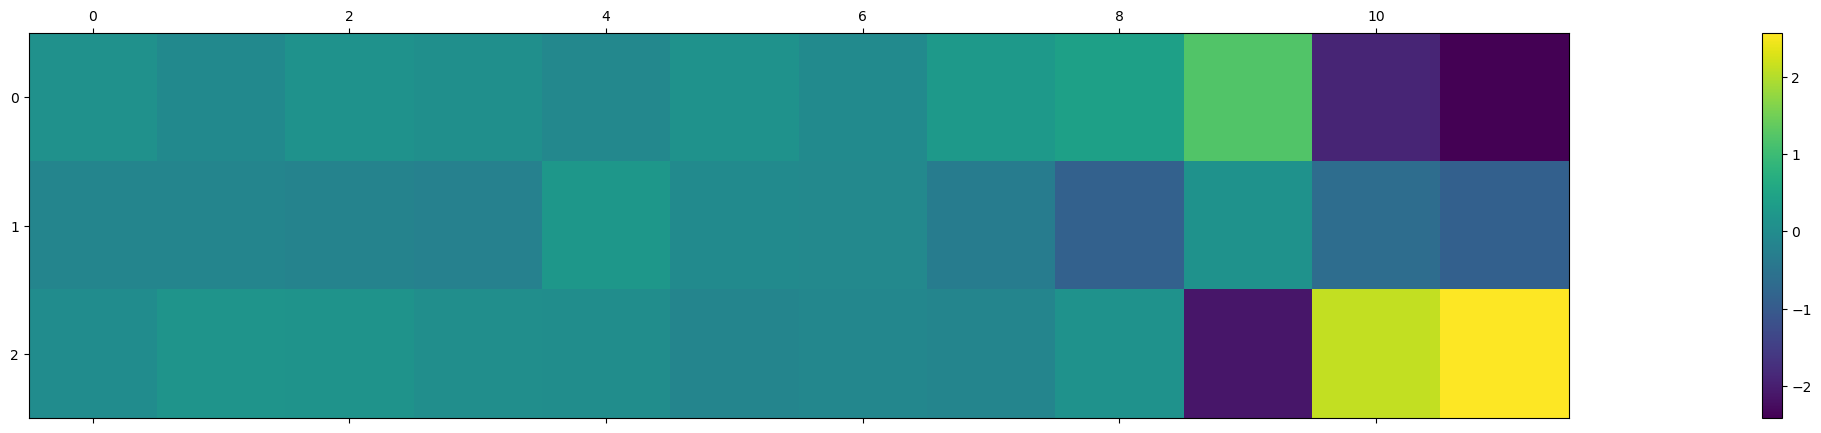

In [31]:
fig = plt.figure(figsize = (50,5))
ax = fig.add_subplot(111)
cax = ax.matshow(rnn_a_sf1.ff1.weight.detach().numpy()[:,45:])
fig.colorbar(cax)
plt.show()

In [43]:
rnn_a_sf1 = rnn_a_sf1.to(device)
sample_pred = rnn_a_sf1(X_val_sn[[4,7]].to(device),sf_val_sn[[4,7]].to(device))
sample_pred

tensor([[9.9951e-01, 3.8257e-07, 4.8749e-04],
        [9.0920e-07, 1.0000e+00, 3.9212e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

[('results', 0.061250445), ('<bos>', 0.24881764), ('cddo-me', 0.013223446), ('is', 0.011249115), ('a', 0.0064124353), ('synthetic', 0.006048956), ('triterpenoid', 0.023531118), ('that', 0.030535098), ('was', 0.007502846), ('under', 0.005357483), ('phase', 0.094296455), ('iii', 0.00789838), ('clinical', 0.03646586), ('development', 0.031817622), ('for', 0.028524796), ('the', 0.0019947882), ('treatment', 0.03591683), ('of', 0.004847311), ('advanced', 0.0063962745), ('chronic', 0.0025681402), ('kidney', 0.0053232107), ('disease', 0.0012506444), ('(', 0.0023818659), ('37', 0.0012370505), (',', 0.0037040056), ('38', 0.004568971), (')', 0.0006878469), ('however', 0.041419685), (',', 0.0023102784), ('due', 0.0059175827), ('to', 0.0028803279), ('adverse', 0.0060621346), ('events', 0.010455315), ('in', 0.0020792822), ('the', 0.0014067289), ('phase', 0.01044383), ('iii', 0.029797057), ('clinical', 0.0029286386), ('trial', 0.0038587109), (',', 0.002556962), ('further', 0.04004141), ('development'

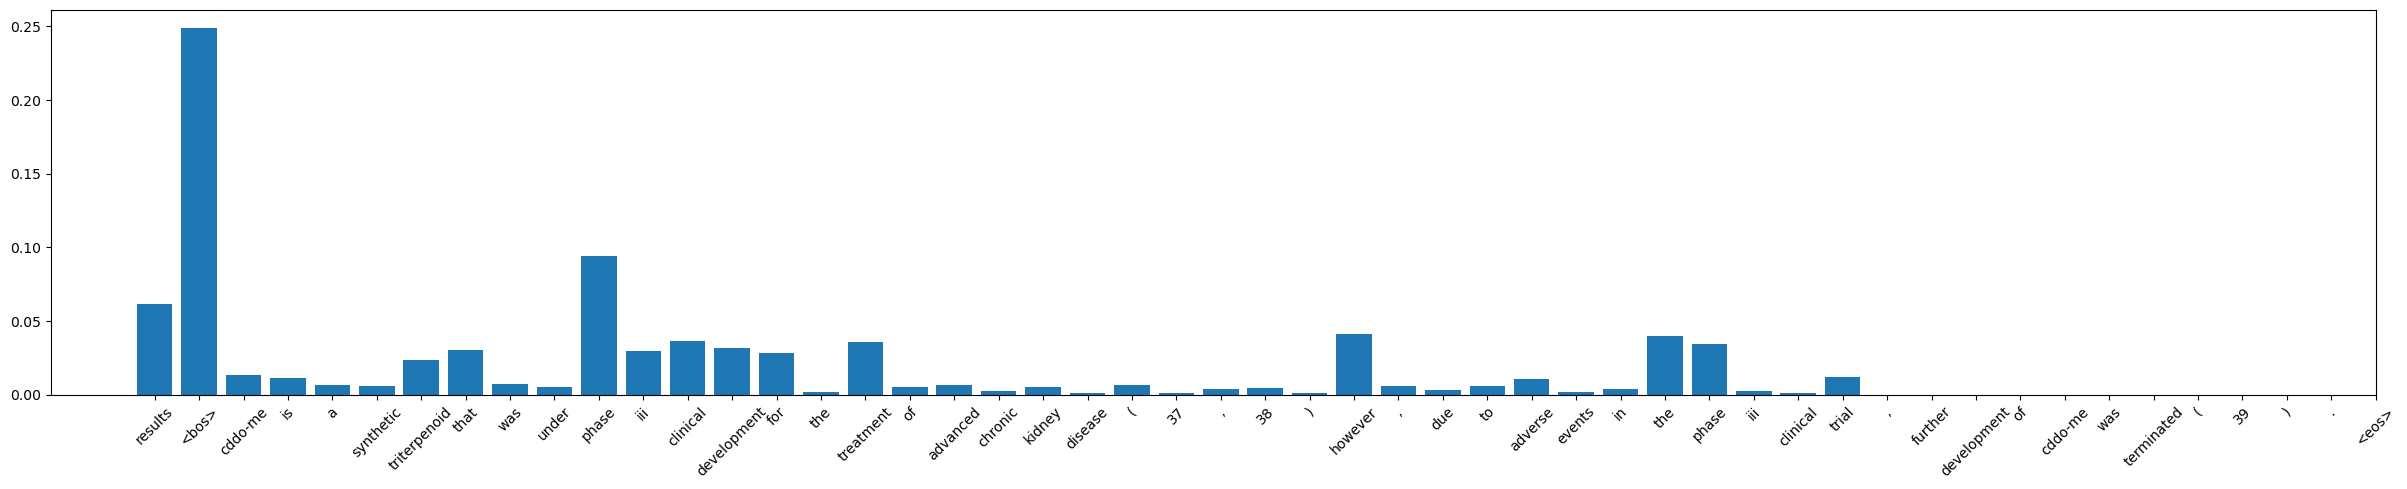

In [25]:
rnn_a_sf1 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                             hidden_size=hidden_size,hidden_size2=hidden_size2,
                             output_size=y_train_sn.shape[1],mode='multihead')
rnn_a_sf1.load_state_dict(torch.load('RNN_Attn_sf_v1.pt'))
plot_attention_weights(4,rnn_a_sf1,sample_string_length=51,tokens_col='tokens_lower_sn')

['methods', '<bos>', 'the', 'remaining', 'descriptive', 'data', 'were', 'collected', 'via', 'observation', 'during', 'the', 'field', 'site', 'characterization', ',', 'and', 'during', 'previous', 'experiments', '[', '19,20', ']', '.', '<eos>']
[0.08461027 0.23196582 0.0009517  0.0371673  0.04260156 0.04709217
 0.00550771 0.06119489 0.009541   0.13942418 0.00352738 0.00186319
 0.04119683 0.04907243 0.03575185 0.00301595 0.00215672 0.00388768
 0.02770216 0.04583992 0.00064493 0.0056896  0.00041212 0.00106295
 0.01021529]


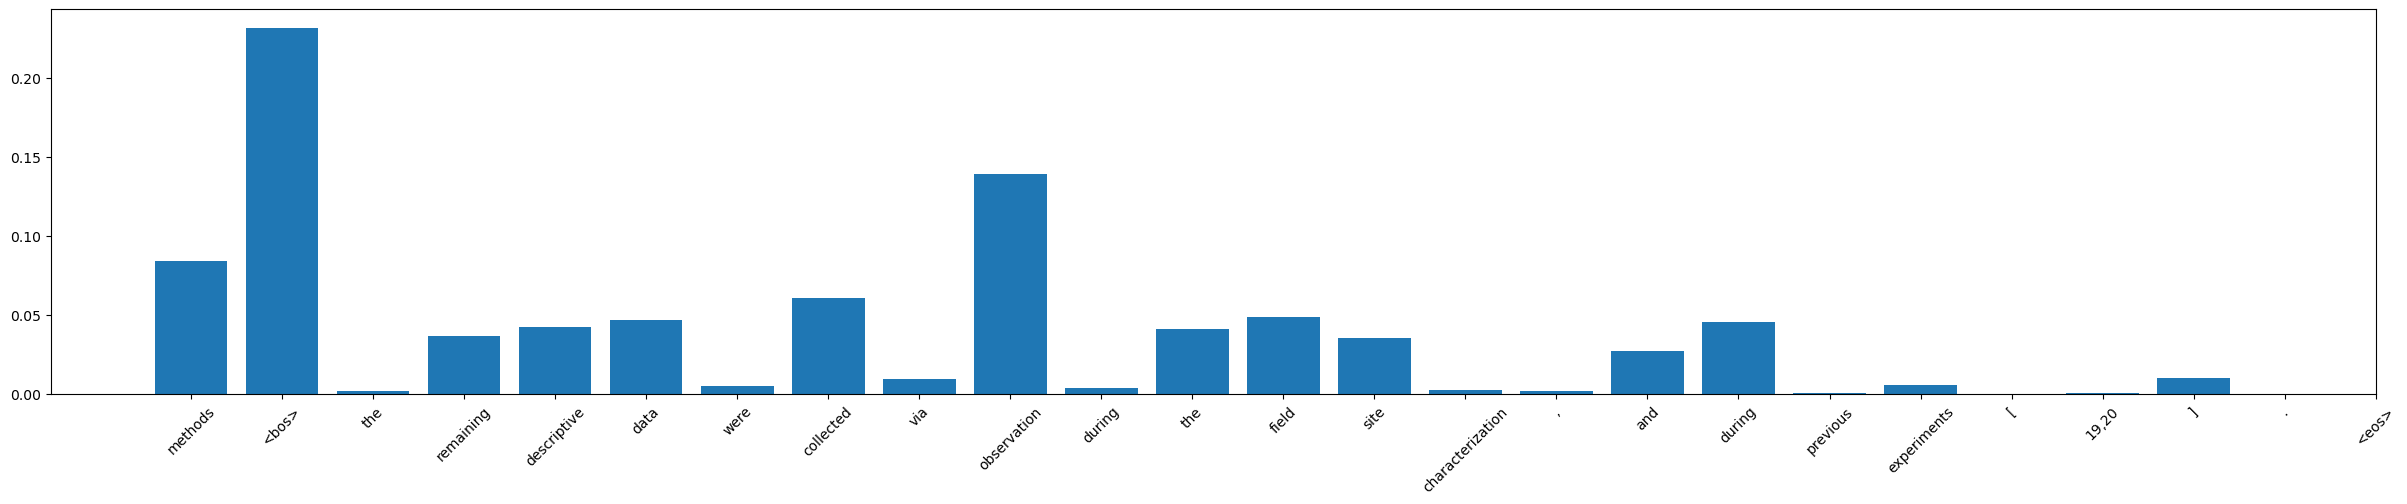

In [37]:
plot_attention_weights(7,rnn_a_sf1,sample_string_length=25,tokens_col='tokens_lower_sn')

B) Indirect Section Headers:

In [38]:
# Generic inclusion
df_train, df_test = add_sectionName(df_train,indirect=True), add_sectionName(df_test,indirect=True)
corpus_sn1 = df_train['tokens_lower_sn1'].tolist()
ft_sn1 = FastText(corpus_sn1,vector_size=vec_size,epochs=10)
# unchanged: sf_core, y_core. Note:
    # sf_core is not a tensor (sf_train and sf_val definitely are, but not sf_train_sn and sf_val_sn)
    # sf_test and y_test no change, as no changes to features and not implicated by the repeat of train-val splits
X_core_sn = generate_X(df_train,'tokens_lower_sn1',
                   ft_sn1,seq_length,vec_size)
X_test_sn = generate_X(df_test,'tokens_lower_sn1',
                   ft_sn1,seq_length,vec_size)
X_train_sn, X_val_sn, sf_train_sn, sf_val_sn, y_train_sn, y_val_sn = train_test_split(X_core_sn,sf_core,y_core,test_size=0.2,random_state= 1)
y_train_sn, y_val_sn_nn = convert_y(y_train_sn),convert_y(y_val_sn)
if torch.is_tensor(sf_test):
    X_train_sn, X_val_sn, X_test_sn, sf_train_sn, sf_val_sn = to_tensor(X_train_sn), to_tensor(X_val_sn), to_tensor(X_test_sn), to_tensor(sf_train_sn.toarray()), to_tensor(sf_val_sn.toarray())
else:
    X_train_sn, X_val_sn, X_test_sn, sf_train_sn, sf_val_sn, sf_test = to_tensor(X_train_sn), to_tensor(X_val_sn), to_tensor(X_test_sn), to_tensor(sf_train_sn.toarray()), to_tensor(sf_val_sn.toarray()), to_tensor(sf_test.toarray())
y_train_sn, y_val_sn_nn = to_tensor(y_train_sn), to_tensor(y_val_sn_nn)

# Quick test; don't need to save tensors

  0%|          | 0/8117 [00:00<?, ?it/s]

  0%|          | 0/1861 [00:00<?, ?it/s]

In [56]:
# HPs
hidden_size = 70
hidden_size2 = 50
batch_size = 2 # OOM when batch_size >= 4
feat_size = sf_train_sn.shape[1]
lr = 0.0002
mode = 'multihead' # default or multihead

# Save memory
for var in models_generated:
    if var in globals(): del var
gc.collect()

# Build and train
'''
RNN_Attn_StatFeat args: input_size,feat_size,hidden_size,hidden_size2,output_size
'''
rnn_a_sf2 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                             hidden_size=hidden_size,hidden_size2=hidden_size2,
                             output_size=y_train_sn.shape[1],mode=mode).to(device)
optimizer = optim.Adam(rnn_a_sf2.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
loader = DataLoader(TensorDataset(X_train_sn.to(device),sf_train_sn.to(device),y_train_sn.to(device)),batch_size=batch_size)
'''
train_and_save args: model,filename,
                   loss_fn,optimizer,
                   loader,
                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs
'''
rnn_a_sf2 = train_and_save(rnn_a_sf2,'RNN_Attn_sf_v2.pt',
                     loss_fn,optimizer,
                     loader,y_val_sn_nn.to(device),y_val_sn,sf=True,X_val=X_val_sn.to(device),sf_val=sf_val_sn.to(device))

  0%|          | 0/40 [00:00<?, ?it/s]

[(0, 1170), (1, 454)]
Epoch1: val loss=0.8130835294723511, balanced accuracy=0.5488584322617936, precision=0.6253614431629775, recall=0.729064039408867, fscore=0.6721432875830368
[(0, 1220), (1, 404)]
Epoch2: val loss=0.8041020631790161, balanced accuracy=0.5509926192699303, precision=0.6396585655597782, recall=0.7413793103448276, fscore=0.682739625806437
[(0, 1100), (1, 368), (2, 156)]
Epoch3: val loss=0.7222662568092346, balanced accuracy=0.7530294946261332, precision=0.8371770616003188, recall=0.8318965517241379, fscore=0.826112846221337
[(0, 1072), (1, 387), (2, 165)]
Epoch4: val loss=0.7137428522109985, balanced accuracy=0.7646386837563308, precision=0.8368467905061701, recall=0.8343596059113301, fscore=0.8298918722456954
[(0, 1022), (1, 405), (2, 197)]
Epoch5: val loss=0.7068847417831421, balanced accuracy=0.7957920541954154, precision=0.8415366478766704, recall=0.8423645320197044, fscore=0.8402096044909967
[(0, 1064), (1, 385), (2, 175)]
Epoch6: val loss=0.7079765200614929, bala

In [39]:
hidden_size = 70
hidden_size2 = 50
feat_size = sf_train_sn.shape[1]
rnn_a_sf2 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                             hidden_size=hidden_size,hidden_size2=hidden_size2,
                             output_size=y_train_sn.shape[1],mode='multihead')
rnn_a_sf2.load_state_dict(torch.load('RNN_Attn_sf_v2.pt'))

<All keys matched successfully>

In [65]:
rnn_a_sf2 = rnn_a_sf2.to(device)
sample_pred = rnn_a_sf2(X_val_sn[[4,7]].to(device),sf_val_sn[[4,7]].to(device))
sample_pred

tensor([[9.9438e-01, 5.0155e-03, 6.0290e-04],
        [1.0093e-06, 9.9998e-01, 2.2192e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [87]:
rnn_a_sf2 = rnn_a_sf2.to(device)
sample_pred = rnn_a_sf2(X_val_sn.to(device),sf_val_sn.to(device))
sample_pred = torch.argmax(sample_pred,1).detach().cpu()
print(classification_report(y_val,sample_pred.numpy()))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       952
           1       0.84      0.73      0.78       441
           2       0.91      0.84      0.87       231

    accuracy                           0.86      1624
   macro avg       0.87      0.84      0.85      1624
weighted avg       0.86      0.86      0.86      1624



['<bos>', 'cddo-me', 'is', 'a', 'synthetic', 'triterpenoid', 'that', 'was', 'under', 'phase', 'iii', 'clinical', 'development', 'for', 'the', 'treatment', 'of', 'advanced', 'chronic', 'kidney', 'disease', '(', '37', ',', '38', ')', 'however', ',', 'due', 'to', 'adverse', 'events', 'in', 'the', 'phase', 'iii', 'clinical', 'trial', ',', 'further', 'development', 'of', 'cddo-me', 'was', 'terminated', '(', '39', ')', '.', '<eos>', '']
[0.05526573 0.00501669 0.00881217 0.00544593 0.03486275 0.01355796
 0.00972873 0.00863134 0.01115784 0.19986421 0.00488185 0.00846257
 0.00786514 0.00244143 0.00759057 0.01729969 0.00100933 0.02903424
 0.00742807 0.00173723 0.00304771 0.00595095 0.00106085 0.01931093
 0.00357117 0.00065404 0.03113962 0.02004567 0.00686716 0.00190335
 0.00676767 0.01137412 0.0023067  0.00446007 0.00868597 0.00664291
 0.00943575 0.00528022 0.01481008 0.0192394  0.00795942 0.00057711
 0.00996719 0.01911823 0.14052658 0.0193198  0.00139167 0.00095369
 0.00521979 0.00266903 0.0013

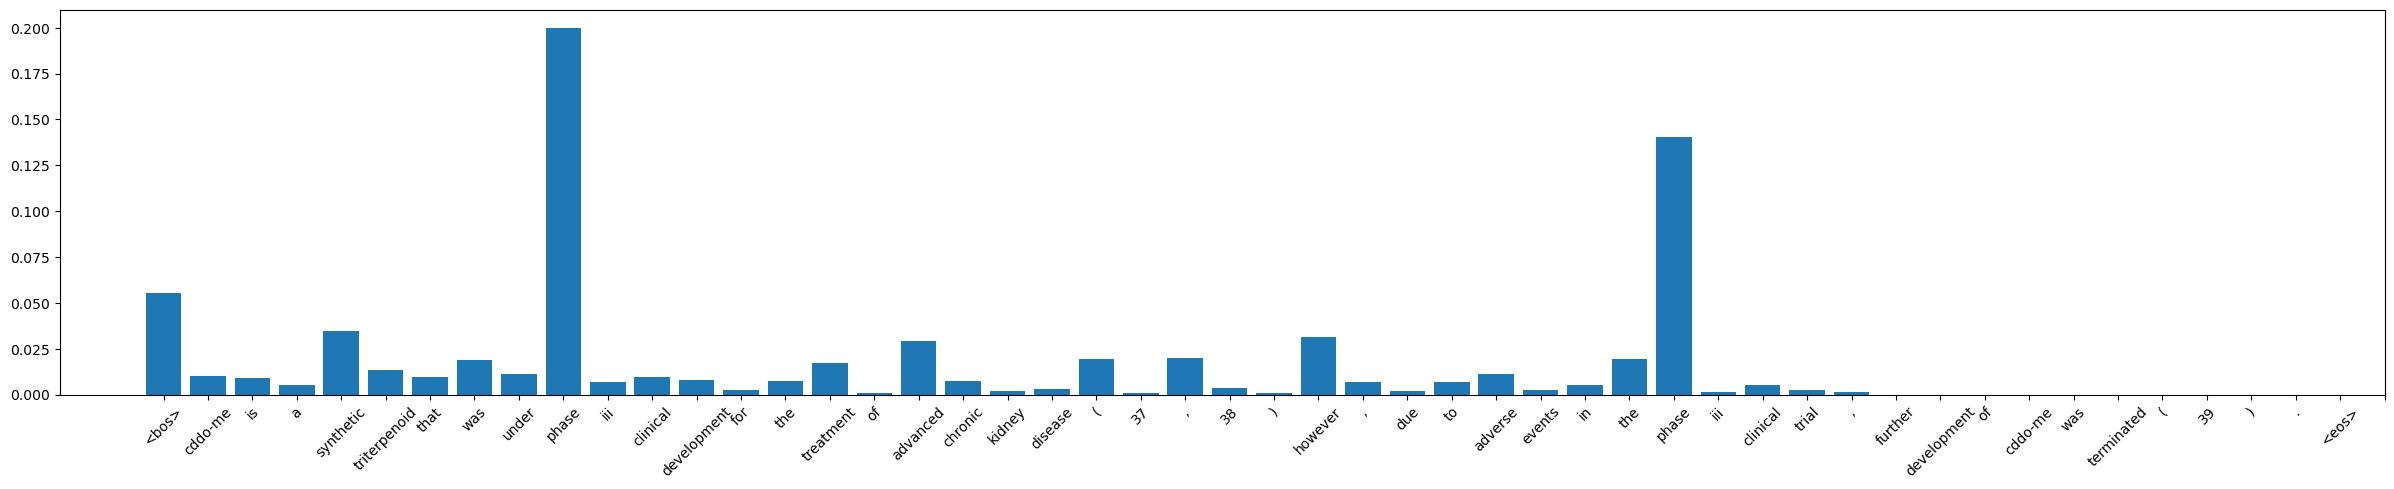

In [40]:
rnn_a_sf2 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                             hidden_size=hidden_size,hidden_size2=hidden_size2,
                             output_size=y_train_sn.shape[1],mode='multihead')

rnn_a_sf2.load_state_dict(torch.load('RNN_Attn_sf_v2.pt'))
plot_attention_weights(4,rnn_a_sf2,tokens_col='tokens_lower_sn1',sample_string_length=51)

['<bos>', 'the', 'remaining', 'descriptive', 'data', 'were', 'collected', 'via', 'observation', 'during', 'the', 'field', 'site', 'characterization', ',', 'and', 'during', 'previous', 'experiments', '[', '19,20', ']', '.', '<eos>', '']
[0.03282072 0.00301166 0.01195996 0.04477693 0.06747384 0.0211642
 0.24845642 0.03652538 0.0481651  0.00341973 0.00586784 0.011816
 0.02937753 0.02284705 0.00913776 0.00278328 0.0013457  0.07396077
 0.15310612 0.0014389  0.01319522 0.00096945 0.00257343 0.0013894
 0.00103495]


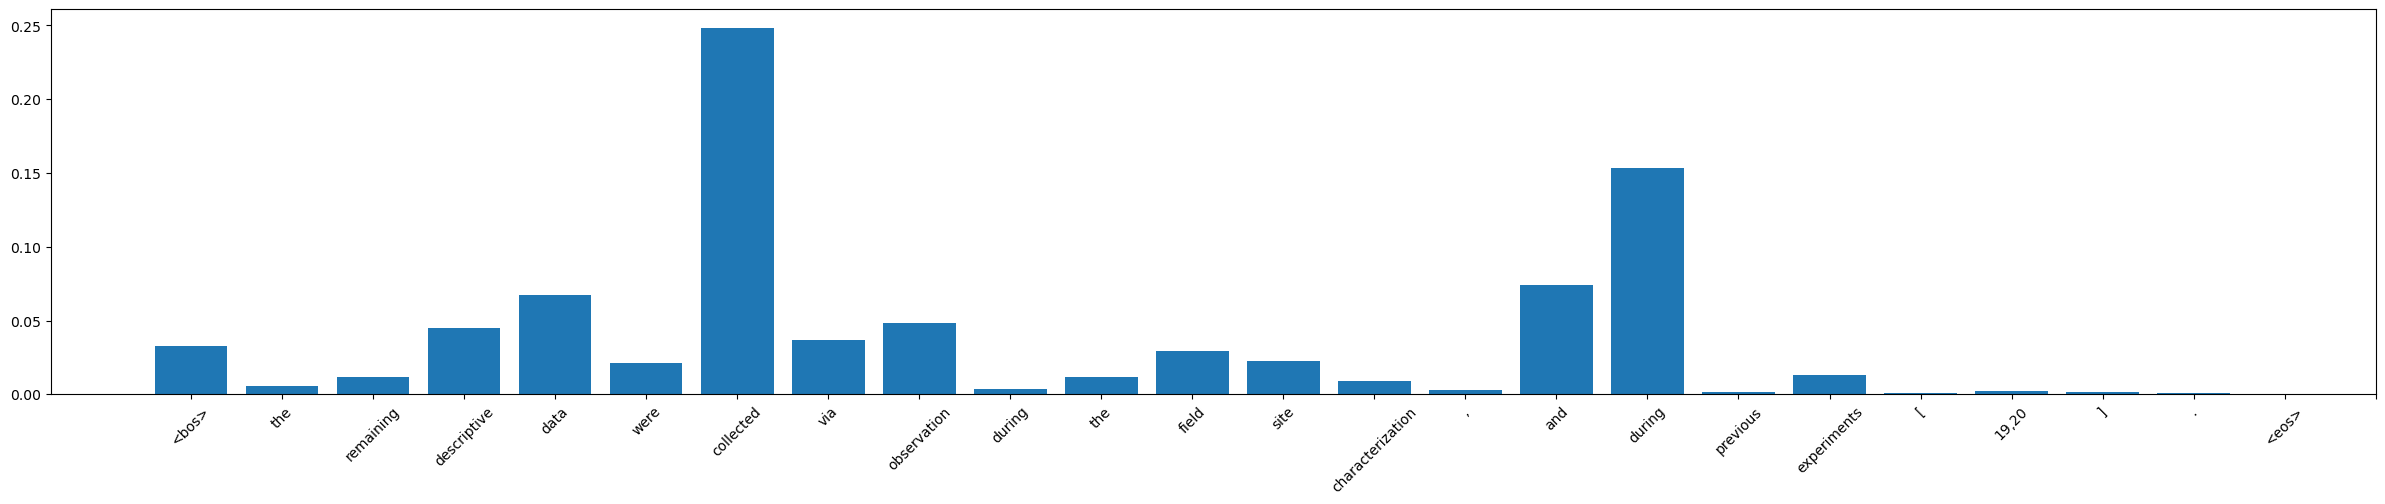

In [41]:
plot_attention_weights(7,rnn_a_sf2,tokens_col='tokens_lower_sn1',sample_string_length=25)

#### SwiGLU Activation Function
RNN_Attn_StatFeat with (full) sectionNames as base

A) SwiGLU (after attention decoder)

In [30]:
# HPs
hidden_size = 70
hidden_size2 = 50
batch_size = 2 # OOM when batch_size >= 4
feat_size = sf_train_sn.shape[1]
lr = 0.0002
mode = 'multihead' # default, multihead
act_fn = 'swiglu' # default, swiglu, swish2, swiglu2

# Save memory
for var in models_generated:
    if var in globals(): del var
gc.collect()

# Build and train
'''
RNN_Attn_StatFeat args: input_size,feat_size,hidden_size,hidden_size2,output_size
'''
rnn_a_sf3 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                             hidden_size=hidden_size,hidden_size2=hidden_size2,
                             output_size=y_train_sn.shape[1],mode=mode,act_fn=act_fn).to(device)
optimizer = optim.Adam(rnn_a_sf3.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
loader = DataLoader(TensorDataset(X_train_sn.to(device),sf_train_sn.to(device),y_train_sn.to(device)),batch_size=batch_size)
'''
train_and_save args: model,filename,
                   loss_fn,optimizer,
                   loader,
                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs
'''
rnn_a_sf3 = train_and_save(rnn_a_sf3,'RNN_Attn_sf_swiglu1.pt',
                     loss_fn,optimizer,
                     loader,y_val_sn_nn.to(device),y_val_sn,sf=True,X_val=X_val_sn.to(device),sf_val=sf_val_sn.to(device))

  0%|          | 0/40 [00:00<?, ?it/s]

[(0, 1624)]
Epoch1: val loss=0.9556695818901062, balanced accuracy=0.3333333333333333, precision=0.34363852556480373, recall=0.5862068965517241, fscore=0.43328335832083953
[(0, 1233), (1, 389), (2, 2)]
Epoch2: val loss=0.8659772872924805, balanced accuracy=0.49519959498951094, precision=0.7299706376366667, recall=0.6915024630541872, fscore=0.6329120131218162
[(0, 1175), (1, 447), (2, 2)]
Epoch3: val loss=0.8488808274269104, balanced accuracy=0.5112059975505353, precision=0.7341281568982752, recall=0.6939655172413793, fscore=0.6395800685589987
[(0, 1101), (1, 519), (2, 4)]
Epoch4: val loss=0.8389424681663513, balanced accuracy=0.5307431053229373, precision=0.7420339872589418, recall=0.6995073891625616, fscore=0.6496044060545757
[(0, 1114), (1, 508), (2, 2)]
Epoch5: val loss=0.8360245227813721, balanced accuracy=0.5353601036374145, precision=0.74642502599405, recall=0.7050492610837439, fscore=0.6526397386703434
[(0, 1082), (1, 532), (2, 10)]
Epoch6: val loss=0.8317307233810425, balanced 

B) Swish (after combined embedding + sf layer)

In [39]:
# HPs
hidden_size = 70
hidden_size2 = 50
batch_size = 2 # OOM when batch_size >= 4
feat_size = sf_train_sn.shape[1]
lr = 0.0002
mode = 'multihead' # default, multihead
act_fn = 'swish2' # default, swiglu, swish2, swiglu2

# Save memory
for var in models_generated:
    if var in globals(): del var
gc.collect()

# Build and train
'''
RNN_Attn_StatFeat args: input_size,feat_size,hidden_size,hidden_size2,output_size
'''
rnn_a_sf3 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                             hidden_size=hidden_size,hidden_size2=hidden_size2,
                             output_size=y_train_sn.shape[1],mode=mode,act_fn=act_fn).to(device)
optimizer = optim.Adam(rnn_a_sf3.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
loader = DataLoader(TensorDataset(X_train_sn.to(device),sf_train_sn.to(device),y_train_sn.to(device)),batch_size=batch_size)
'''
train_and_save args: model,filename,
                   loss_fn,optimizer,
                   loader,
                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs
'''
rnn_a_sf3 = train_and_save(rnn_a_sf3,'RNN_Attn_sf_swish2.pt',
                     loss_fn,optimizer,
                     loader,y_val_sn_nn.to(device),y_val_sn,sf=True,X_val=X_val_sn.to(device),sf_val=sf_val_sn.to(device))

  0%|          | 0/40 [00:00<?, ?it/s]

[(0, 1160), (1, 460), (2, 4)]
Epoch1: val loss=0.8377026915550232, balanced accuracy=0.5314014494686764, precision=0.6102785891536989, recall=0.7112068965517241, fscore=0.6560808581432218
[(0, 1049), (1, 416), (2, 159)]
Epoch2: val loss=0.7019111514091492, balanced accuracy=0.7992151406016953, precision=0.8622832065969106, recall=0.8559113300492611, fscore=0.8535933229108607
[(0, 1165), (1, 296), (2, 163)]
Epoch3: val loss=0.7462673783302307, balanced accuracy=0.7334918816011253, precision=0.8177980592698664, recall=0.8054187192118226, fscore=0.7957479640581115
[(0, 1069), (1, 391), (2, 164)]
Epoch4: val loss=0.7095135450363159, balanced accuracy=0.7835154263725692, precision=0.8450747216222956, recall=0.8386699507389163, fscore=0.8359059535723791
[(0, 1055), (1, 399), (2, 170)]
Epoch5: val loss=0.6928243041038513, balanced accuracy=0.8075851552742309, precision=0.8617330833211481, recall=0.8559113300492611, fscore=0.8540573726864393
[(0, 1045), (1, 409), (2, 170)]
Epoch6: val loss=0.6

C) SwiGLU (after combined embedding + sf layer) 

In [37]:
# HPs
hidden_size = 70
hidden_size2 = 50
batch_size = 2 # OOM when batch_size >= 4
feat_size = sf_train_sn.shape[1]
lr = 0.0002
mode = 'multihead' # default, multihead
act_fn = 'swiglu2' # default, swiglu, swish2, swiglu2

# Save memory
for var in models_generated:
    if var in globals(): del var
gc.collect()

# Build and train
'''
RNN_Attn_StatFeat args: input_size,feat_size,hidden_size,hidden_size2,output_size
'''
rnn_a_sf3 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                             hidden_size=hidden_size,hidden_size2=hidden_size2,
                             output_size=y_train_sn.shape[1],mode=mode,act_fn=act_fn).to(device)
optimizer = optim.Adam(rnn_a_sf3.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
loader = DataLoader(TensorDataset(X_train_sn.to(device),sf_train_sn.to(device),y_train_sn.to(device)),batch_size=batch_size)
'''
train_and_save args: model,filename,
                   loss_fn,optimizer,
                   loader,
                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs
'''
rnn_a_sf3 = train_and_save(rnn_a_sf3,'RNN_Attn_sf_swiglu2.pt',
                     loss_fn,optimizer,
                     loader,y_val_sn_nn.to(device),y_val_sn,sf=True,X_val=X_val_sn.to(device),sf_val=sf_val_sn.to(device))

  0%|          | 0/40 [00:00<?, ?it/s]

[(0, 1340), (1, 284)]
Epoch1: val loss=0.8540717959403992, balanced accuracy=0.40719065403939353, precision=0.5100799275840322, recall=0.6354679802955665, fscore=0.5547400979055517
[(0, 962), (1, 443), (2, 219)]
Epoch2: val loss=0.7788861393928528, balanced accuracy=0.7695451918140993, precision=0.8053864382420648, recall=0.8060344827586207, fscore=0.8056224218065862
[(0, 940), (1, 451), (2, 233)]
Epoch3: val loss=0.765296220779419, balanced accuracy=0.7862392431720163, precision=0.8117803423934973, recall=0.8109605911330049, fscore=0.8113225223252254
[(0, 999), (1, 452), (2, 173)]
Epoch4: val loss=0.7358171939849854, balanced accuracy=0.7667284085351312, precision=0.8208317821063138, recall=0.8201970443349754, fscore=0.8180260798164223
[(0, 1097), (1, 414), (2, 113)]
Epoch5: val loss=0.7447079420089722, balanced accuracy=0.7029493615628071, precision=0.8133040120334796, recall=0.8066502463054187, fscore=0.7960978371672194
[(0, 1102), (1, 433), (2, 89)]
Epoch6: val loss=0.7478877902030

#### Word Order
Based on RNN_Attn_StatFeat with sectionName

##### For Subsequent Runs (Tensors Saved), Ignore this Cell:

In [ ]:
# Generic inclusion
def randomize_tokens(tk_list,rng):
    '''
    Based on tokens with sectionName
    Keep positions of: sectionName bos, eos
    '''
    target_list = tk_list[2:-1]
    reordered_list = tk_list[:2] + rng.permutation(target_list).tolist() + [tk_list[-1]]
    return reordered_list

def generate_reordered_tokens(df):
    rng1 = np.random.default_rng()
    df['tokens_lower_sn_jumbled'] = df['tokens_lower_sn'].apply(lambda x:randomize_tokens(x,rng1))
    return df

# Regenerate col again (in case the cell above hasn't been run)
df_train, df_test = add_sectionName(df_train), add_sectionName(df_test)
df_train, df_test = generate_reordered_tokens(df_train), generate_reordered_tokens(df_test)
# unchanged: sf_core, y_core. Note:
    # sf_core is not a tensor (sf_train and sf_val definitely are, but not sf_train_sn and sf_val_sn)
    # y_test has already been loaded
    # sf_test and y_test no change, as no changes to features and not implicated by the repeat of train-val splits
X_core_sn_ro = generate_X(df_train,'tokens_lower_sn',
                   ft,seq_length,vec_size)
X_test_sn_ro = generate_X(df_test,'tokens_lower_sn',
                   ft,seq_length,vec_size)
X_train_sn_ro, X_val_sn_ro, sf_train_sn_ro, sf_val_sn_ro, y_train_sn_ro, y_val_sn_ro = train_test_split(X_core_sn_ro,sf_core,y_core,test_size=0.2,random_state= 1)
y_train_sn_ro, y_val_sn_ro_nn = convert_y(y_train_sn_ro),convert_y(y_val_sn_ro)
if torch.is_tensor(sf_test): # Depends on whether sf_test has been loaded as or converted to tensor previously
    X_train_sn_ro, X_val_sn_ro, X_test_sn_ro, sf_train_sn_ro, sf_val_sn_ro = to_tensor(X_train_sn_ro), to_tensor(X_val_sn_ro), to_tensor(X_test_sn_ro), to_tensor(sf_train_sn_ro.toarray()), to_tensor(sf_val_sn_ro.toarray())
else:
    X_train_sn_ro, X_val_sn_ro, X_test_sn_ro, sf_train_sn_ro, sf_val_sn_ro, sf_test = to_tensor(X_train_sn_ro), to_tensor(X_val_sn_ro), to_tensor(X_test_sn_ro), to_tensor(sf_train_sn_ro.toarray()), to_tensor(sf_val_sn_ro.toarray()), to_tensor(sf_test.toarray())
y_train_sn_ro, y_val_sn_ro_nn = to_tensor(y_train_sn_ro), to_tensor(y_val_sn_ro_nn)
torch.save([X_train_sn_ro,X_val_sn_ro,X_test_sn_ro,sf_train_sn_ro,sf_val_sn_ro,sf_test,y_train_sn_ro,y_val_sn_ro_nn],'data_arrays_sn_ro_v0.pt') # embeddings only
np.savez('y_arr_sn_ro_v0.npz',y_val=y_val_sn_ro,y_test=y_test)

##### For Subsequent Runs (Tensors Saved), Resume from this Cell:

In [ ]:
X_train_sn_ro,X_val_sn_ro,X_test_sn_ro,sf_train_sn_ro,sf_val_sn_ro,sf_test,y_train_sn_ro,y_val_sn_ro_nn = torch.load('data_arrays_sn_ro_v0.pt')
data_sn = np.load('y_arr_sn_ro_v0.npz')
y_val_sn_ro = data_sn['y_val']
y_test = data_sn['y_test']

In [ ]:
# HPs
hidden_size = 70
hidden_size2 = 50
batch_size = 2 # OOM when batch_size >= 4
feat_size = sf_train_sn_ro.shape[1]
lr = 0.0002

# Save memory
for var in models_generated:
    if var in globals(): del var
gc.collect()

# Build and train
'''
RNN_Attn_StatFeat args: input_size,feat_size,hidden_size,hidden_size2,output_size
'''
rnn_a_sf2 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                             hidden_size=hidden_size,hidden_size2=hidden_size2,
                             output_size=y_train_sn_ro.shape[1]).to(device)
optimizer = optim.Adam(rnn_a_sf2.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
loader = DataLoader(TensorDataset(X_train_sn_ro.to(device),sf_train_sn_ro.to(device),y_train_sn_ro.to(device)),batch_size=batch_size)
'''
train_and_save args: model,filename,
                   loss_fn,optimizer,
                   loader,
                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs
'''
rnn_a_sf2 = train_and_save(rnn_a_sf2,'RNN_Attn_sf_v2.pt',
                     loss_fn,optimizer,
                     loader,y_val_sn_ro_nn.to(device),y_val_sn_ro,sf=True,X_val=X_val_sn_ro.to(device),sf_val=sf_val_sn_ro.to(device))

#### Pulling Contextual Paper Info

In [18]:
import requests

In [96]:
paper = requests.get(r'https://api.semanticscholar.org/graph/v1/paper/1872080baa7d30ec8fb87be9a65358cd3a7fb649?fields=url')

In [97]:
paper.content

b'{"message": "Too Many Requests. Please wait and try again or apply for a key for higher rate limits. https://www.semanticscholar.org/product/api#api-key-form", "code": "429"}'

#### Additional Hidden Layer for Static Features
*Using full sectionNames. No special activation functions (e.g. swish, swiglu)

A) Add hidden layer after combined FF layer

In [15]:
# HPs
hidden_size = 70
hidden_size2 = 50
hidden_size3 = 40
batch_size = 2 # OOM when batch_size >= 4
feat_size = sf_train_sn.shape[1]
lr = 0.0002
mode = 'multihead' # default, multihead
hidden_pos = 'combined' # None, combined, attn

# Save memory
for var in models_generated:
    if var in globals(): del var
gc.collect()

# Build and train
'''
RNN_Attn_StatFeat args: input_size,feat_size,hidden_size,hidden_size2,output_size
'''
rnn_a_sf3 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                              hidden_size=hidden_size,hidden_size2=hidden_size2,
                              output_size=y_train_sn.shape[1],mode=mode,
                              hidden_size3=hidden_size3,hidden_pos=hidden_pos).to(device)
optimizer = optim.Adam(rnn_a_sf3.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
loader = DataLoader(TensorDataset(X_train_sn.to(device),sf_train_sn.to(device),y_train_sn.to(device)),batch_size=batch_size)
'''
train_and_save args: model,filename,
                   loss_fn,optimizer,
                   loader,
                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs
'''
rnn_a_sf3 = train_and_save(rnn_a_sf3,'RNN_Attn_sf_hidden1.pt',
                     loss_fn,optimizer,
                     loader,y_val_sn_nn.to(device),y_val_sn,sf=True,X_val=X_val_sn.to(device),sf_val=sf_val_sn.to(device))

  0%|          | 0/40 [00:00<?, ?it/s]

[(0, 1209), (1, 415)]
Epoch1: val loss=0.809536337852478, balanced accuracy=0.553426926326086, precision=0.6388610401218118, recall=0.7413793103448276, fscore=0.6830881585911321
[(0, 974), (1, 427), (2, 223)]
Epoch2: val loss=0.7136368155479431, balanced accuracy=0.7983107384367889, precision=0.8291196809399262, recall=0.8300492610837439, fscore=0.8294291469310564
[(0, 1066), (1, 397), (2, 161)]
Epoch3: val loss=0.7013942003250122, balanced accuracy=0.7783062720037511, precision=0.8470362336261911, recall=0.8423645320197044, fscore=0.8388498919212991
[(0, 983), (1, 436), (2, 205)]
Epoch4: val loss=0.6815634369850159, balanced accuracy=0.8409732579900647, precision=0.8661412124514757, recall=0.8657635467980296, fscore=0.8653729499980098
[(0, 1015), (1, 405), (2, 204)]
Epoch5: val loss=0.6765461564064026, balanced accuracy=0.8411177602354073, precision=0.873347333384404, recall=0.8731527093596059, fscore=0.8718321782814367
[(0, 1039), (1, 384), (2, 201)]
Epoch6: val loss=0.67694193124771

B) Add hidden layer after attention decoder layer

In [41]:
# HPs
hidden_size = 70
hidden_size2 = 50
hidden_size3 = 40
batch_size = 2 # OOM when batch_size >= 4
feat_size = sf_train_sn.shape[1]
lr = 0.0002
mode = 'multihead' # default, multihead
hidden_pos = 'attn' # None, combined, attn

# Save memory
for var in models_generated:
    if var in globals(): del var
gc.collect()

# Build and train
'''
RNN_Attn_StatFeat args: input_size,feat_size,hidden_size,hidden_size2,output_size
'''
rnn_a_sf3 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                              hidden_size=hidden_size,hidden_size2=hidden_size2,
                              output_size=y_train_sn.shape[1],mode=mode,
                              hidden_size3=hidden_size3,hidden_pos=hidden_pos).to(device)
optimizer = optim.Adam(rnn_a_sf3.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
loader = DataLoader(TensorDataset(X_train_sn.to(device),sf_train_sn.to(device),y_train_sn.to(device)),batch_size=batch_size)
'''
train_and_save args: model,filename,
                   loss_fn,optimizer,
                   loader,
                   y_val_nn,y_val,n_epochs=40,sf=False,**kwargs
'''
rnn_a_sf3 = train_and_save(rnn_a_sf3,'RNN_Attn_sf_hidden2.pt',
                     loss_fn,optimizer,
                     loader,y_val_sn_nn.to(device),y_val_sn,sf=True,X_val=X_val_sn.to(device),sf_val=sf_val_sn.to(device))

  0%|          | 0/40 [00:00<?, ?it/s]

[(0, 1072), (1, 552)]
Epoch1: val loss=0.8204354643821716, balanced accuracy=0.5647203325774754, precision=0.622382954977735, recall=0.7241379310344828, fscore=0.669018758953399
[(0, 1199), (1, 425)]
Epoch2: val loss=0.7993851900100708, balanced accuracy=0.5615023787292696, precision=0.6432736035946115, recall=0.7463054187192119, fscore=0.6883516696175991
[(0, 1043), (1, 430), (2, 151)]
Epoch3: val loss=0.7154766321182251, balanced accuracy=0.7613858674783045, precision=0.8363446415645229, recall=0.8343596059113301, fscore=0.8297043891668177
[(0, 1120), (1, 395), (2, 109)]
Epoch4: val loss=0.7232876420021057, balanced accuracy=0.7148111769960509, precision=0.8329929841141444, recall=0.8208128078817734, fscore=0.8101528111523307
[(0, 1042), (1, 408), (2, 174)]
Epoch5: val loss=0.7032790184020996, balanced accuracy=0.7826580127000294, precision=0.8442390468343828, recall=0.8435960591133005, fscore=0.8403900107689862
[(0, 1029), (1, 421), (2, 174)]
Epoch6: val loss=0.7018424868583679, bal

#### Miscellaneous

Check distribution of direct and indirect section names

In [18]:
def map_sn_to_label(row):
    target_labels = ['method','background','result']
    result = 0
    for L in target_labels:
        if L in row.sectionName.lower():
            result = 1
            if row.label == L:
                result = 2
                break
            else:
                break
    return result

df_train['label_sectionName'] = df_train.apply(lambda row: map_sn_to_label(row),axis=1)

In [24]:
'''
type 0: no match
type 1: section name contains a label (label0), but label0 != the sample's label
type 2: section name contains a label (label0), and label0 == the sample's label
'''
sn_counts = df_train['label_sectionName'].value_counts().tolist()
sn_types = df_train['label_sectionName'].value_counts().index.tolist()
sn_dist0 = list(zip(sn_types,sn_counts))
sn_dist = pd.DataFrame(sn_dist0,columns=['type','counts'])
sn_dist = sn_dist.set_index('type',drop=True)
sn_dist['pct'] = sn_dist['counts']/sn_dist['counts'].sum()
sn_dist

counts       pct
type                  
0       5721  0.704817
2       1449  0.178514
1        947  0.116669

Compare prediction results for samples where key words are at opposing ends of the string

In [20]:
import json

df_train, df_test = add_sectionName(df_train), add_sectionName(df_test)
sample_data = []
with open(r'attention_data.jsonl') as f:
    for line in f:
        sample_data.append(json.loads(line))
sample_df = pd.DataFrame.from_records(sample_data)
sample_df = process_df(sample_df)
sample_df = sample_df.loc[sample_df['tokens_lower'].str.len() <= 100]
sample_df = sample_df.reset_index(drop=True)
sample_df = add_sectionName(sample_df)
sf_sample = generate_static_features(sample_df)
corpus_sn = df_train['tokens_lower_sn'].tolist()
ft_sn = FastText(corpus_sn,vector_size=vec_size,epochs=10)
X_sample = generate_X(sample_df,'tokens_lower_sn',
                   ft_sn,seq_length,vec_size)
X_sample, sf_sample = to_tensor(X_sample), to_tensor(sf_sample.toarray())

def generate_final_pred(sample_pred):
    final_pred = []
    for i in sample_pred:
        if i == 0:
            final_pred.append('background')
        elif i == 1:
            final_pred.append('method')
        else:
            final_pred.append('result')
    return final_pred

  0%|          | 0/16 [00:00<?, ?it/s]

In [26]:
hidden_size=150
rnn0 = nn.Sequential(
    generate_h(hidden_size),
    RNN_wrapper(vec_size,hidden_size,batch_first=True),
    extract_h(),
    nn.Linear(hidden_size,y_train.shape[1])
)
rnn0.load_state_dict(torch.load('RNN_v1.pt'))
ff1_w = rnn0[3].weight
rnn_w = rnn0[1].rnn.all_weights[0]
rnn0 = rnn0.to(device)
sample_pred = rnn0(X_sample.to(device))
sample_pred = torch.argmax(sample_pred,1).cpu().detach().numpy()
final_pred = generate_final_pred(sample_pred)
comparison = list(zip(sample_df['label'].tolist(),final_pred))
comparison

[('result', 'method'),
 ('result', 'method'),
 ('method', 'method'),
 ('method', 'method'),
 ('method', 'background'),
 ('background', 'background'),
 ('background', 'background'),
 ('result', 'background'),
 ('result', 'background'),
 ('result', 'background'),
 ('method', 'background'),
 ('method', 'method'),
 ('background', 'background'),
 ('background', 'background'),
 ('background', 'background'),
 ('background', 'method')]

In [59]:
hidden_size = 70
hidden_size2 = 50
feat_size = sf_train_sn.shape[1]
rnn_a_sf1 = RNN_Attn_StatFeat(input_size=vec_size,feat_size=feat_size,
                             hidden_size=hidden_size,hidden_size2=hidden_size2,
                             output_size=y_train_sn.shape[1],mode='multihead')
rnn_a_sf1.load_state_dict(torch.load('RNN_Attn_sf_v1.pt'))
rnn_a_sf1 = rnn_a_sf1.to(device)
sample_pred = rnn_a_sf1(X_sample.to(device),sf_sample.to(device))
sample_pred = torch.argmax(sample_pred,1).cpu().detach().numpy()
final_pred = generate_final_pred(sample_pred)
comparison = list(zip(sample_df['label'].tolist(),final_pred))
comparison

[('result', 'result'),
 ('result', 'result'),
 ('method', 'method'),
 ('method', 'method'),
 ('method', 'background'),
 ('background', 'background'),
 ('background', 'background'),
 ('result', 'result'),
 ('result', 'result'),
 ('result', 'background'),
 ('method', 'background'),
 ('method', 'method'),
 ('background', 'background'),
 ('background', 'background'),
 ('background', 'background'),
 ('background', 'background')]

In [27]:
df_train['label2'].value_counts()

label2
cant_determine    7306
not_supportive     462
supportive         349
Name: count, dtype: int64

Summary of results

In [ ]:
'''
Results:
- RNN default - Epoch1: val loss=1.5992647409439087, balanced accuracy=0.33408919123204833, precision=0.479838109613504, recall=0.5868226600985221, fscore=0.4348459869787806
- RNN Sequential - Epoch3: val loss=1.6012455224990845, balanced accuracy=0.3401082655284336, precision=0.4246488499234758, recall=0.43472906403940886, fscore=0.4174141446551811
- RNN_Attn - Epoch13: val loss=0.45884597301483154, balanced accuracy=0.755593651602055, precision=0.8039308068696814, recall=0.8060344827586207, fscore=0.8028471981210324
- RNN_Attn_StatFeat - Epoch29: val loss=0.6968145370483398, balanced accuracy=0.819888056232594, precision=0.8485338182885594, recall=0.8497536945812808, fscore=0.8471742309103825

- RNN_Attn_StatFeat with sectionName - Epoch26: val loss=0.6687561273574829, balanced accuracy=0.8488238729835368, precision=0.8824253380976532, recall=0.8811576354679803, fscore=0.879580416187504
- RNN_Attn_StatFeat with 'indirect' sectionName - Epoch18: val loss=0.6923820376396179, balanced accuracy=0.8107722887134652, precision=0.8572329364525372, recall=0.8559113300492611, fscore=0.8534285666509048

- RNN_Attn_StatFeat with sectionName and SwiGLU after decoder - Epoch10: val loss=0.795891523361206, balanced accuracy=0.7006524832155083, precision=0.8030767639690778, recall=0.7629310344827587, fscore=0.75950573081338
- RNN_Attn_StatFeat with sectionName and SwiGLU in combined layer - Epoch28: val loss=0.6779072284698486, balanced accuracy=0.852150961394659, precision=0.8749802799988988, recall=0.874384236453202, fscore=0.8740519437287633
- RNN_Attn_StatFeat with sectionName and Swish in combined layer - Epoch9: val loss=0.6849693059921265, balanced accuracy=0.8226856399125305, precision=0.8690703125379914, recall=0.8639162561576355, fscore=0.8631333389848559

- RNN_Attn_StatFeat with sectionName and extra hidden layer in combined section - Epoch16: val loss=0.6702285408973694, balanced accuracy=0.8536662139603317, precision=0.8789520089446614, recall=0.8786945812807881, fscore=0.8779289688818548
- RNN_Attn_StatFeat with sectionName and extra hidden layer after decoder - Epoch24: val loss=0.6741236448287964, balanced accuracy=0.8441674649657843, precision=0.8793324130352373, recall=0.8780788177339901, fscore=0.8770049519200416

Observations:
- Results (esp for RNN_Attn) are worse with softmax than without. Seems to apply to activation functions in general

Actions taken to address problem of assigning all samples to one class:
- Removed outlier samples with extremely high word counts (>100) (worked for Attn. RNN unaffected)
- Resampling (tried for RNN; didn't work)
- Weighted loss (tried for RNN; didn't work)
'''
no_print = True